In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage

%matplotlib inline

In [2]:
mni = nib.load('../data/MNI152_T1_1mm_brain.nii.gz')

## Cho

In [3]:
cho = nib.load('../data/Cho_Braak_w_hipp_labels_gk.nii.gz')

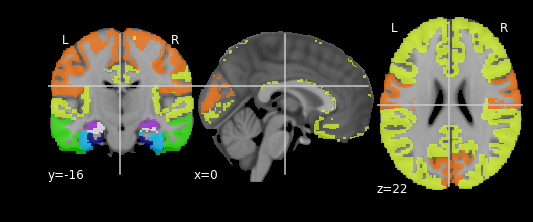

In [4]:
plotting.plot_roi(cho, mni)

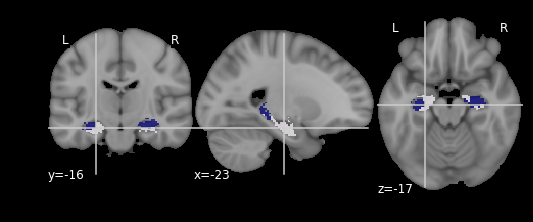

In [5]:
cho_hippo_data = deepcopy(cho.get_data())
cho_hippo_data[cho_hippo_data < 6] = 0  # Hippocampal labels are 6 and 7, remove all others
cho_hippo = nib.Nifti1Image(cho_hippo_data, cho.affine, cho.header)
plotting.plot_roi(cho_hippo, mni)

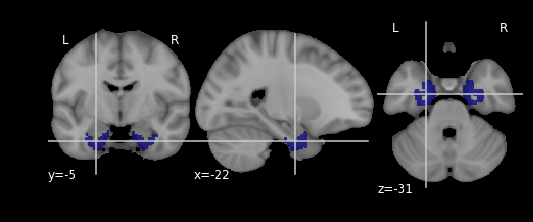

In [6]:
cho_erc_data = deepcopy(cho.get_data())
cho_erc_data[cho_erc_data > 1] = 0  # ERC label is 1, remove all others
cho_erc = nib.Nifti1Image(cho_erc_data, cho.affine, cho.header)
plotting.plot_roi(cho_erc, mni)

### Split into LR

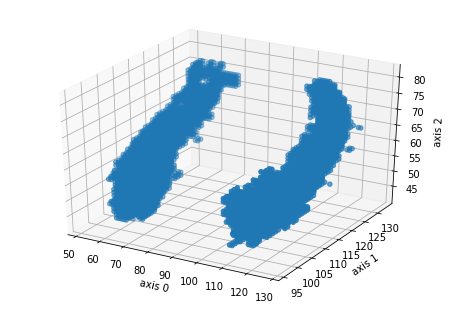

In [7]:
label_locations = np.where(cho_hippo_data > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2])
# To split into LR, we need to visualize where the LR split is, where front is

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()

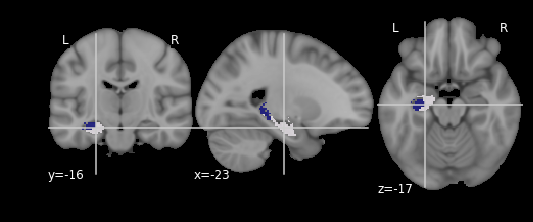

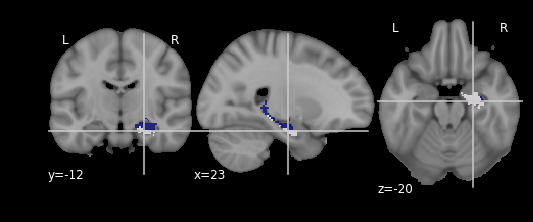

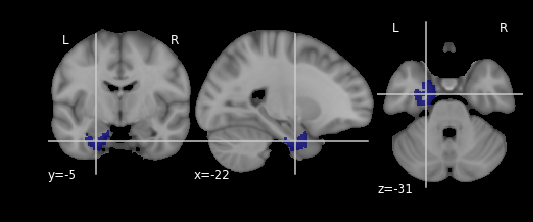

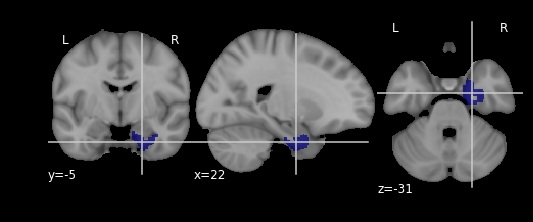

In [8]:
# From the above, we can split the LR data at x=90, and front is lower in y=0
# Thus, Left: x > 90, Right: x <= 90
boundary = 90
x_locations = set([x for x, y, z in zip(*label_locations)])
left_label_locations  = [(x, y, z) for x, y, z in zip(*label_locations) if x > 90]
right_label_locations = [(x, y, z) for x, y, z in zip(*label_locations) if x <= 90]


cho_hippo_left_data = deepcopy(cho_hippo_data)
cho_hippo_left_data[0:boundary,:,:] = 0
cho_hippo_left = nib.Nifti1Image(cho_hippo_left_data, cho.affine, cho.header)

cho_hippo_right_data = deepcopy(cho_hippo_data)
cho_hippo_right_data[boundary:,:,:] = 0
cho_hippo_right = nib.Nifti1Image(cho_hippo_right_data, cho.affine, cho.header)

cho_erc_left_data = deepcopy(cho_erc_data)
cho_erc_left_data[0:boundary,:,:] = 0
cho_erc_left = nib.Nifti1Image(cho_erc_left_data, cho.affine, cho.header)

cho_erc_right_data = deepcopy(cho_erc_data)
cho_erc_right_data[boundary:,:,:] = 0
cho_erc_right = nib.Nifti1Image(cho_erc_right_data, cho.affine, cho.header)

plotting.plot_roi(cho_hippo_left, mni)
plotting.plot_roi(cho_hippo_right, mni)
plotting.plot_roi(cho_erc_left, mni)
plotting.plot_roi(cho_erc_right, mni)

In [9]:
nib.save(cho_hippo_left, '../data/Cho_Braak_w_hipp_labels_left_gk.nii.gz')
nib.save(cho_hippo_right, '../data/Cho_Braak_w_hipp_labels_right_gk.nii.gz')
nib.save(cho_erc_left, '../data/Cho_Braak_w_erc_labels_left_gk.nii.gz')
nib.save(cho_erc_right, '../data/Cho_Braak_w_erc_labels_right_gk.nii.gz')

#### Load left-right parcellations (if not generated above)

In [10]:
cho_hippo_left = nib.load('../data/Cho_Braak_w_hipp_labels_left_gk.nii.gz')
cho_hippo_left_data = cho_hippo_left.get_data()

cho_hippo_right = nib.load('../data/Cho_Braak_w_hipp_labels_right_gk.nii.gz')
cho_hippo_right_data = cho_hippo_right.get_data()

cho_erc_left = nib.load('../data/Cho_Braak_w_erc_labels_left_gk.nii.gz')
cho_erc_left_data = cho_erc_left.get_data()

cho_erc_right = nib.load('../data/Cho_Braak_w_erc_labels_right_gk.nii.gz')
cho_erc_right_data = cho_erc_right.get_data()

### Weight by region size

In [11]:
cho_hippo_left_sizes = dict(zip(*np.unique(cho_hippo_left_data, return_counts=True)))
del cho_hippo_left_sizes[0.0]
print("Left: {}".format(cho_hippo_left_sizes))


cho_hippo_right_sizes = dict(zip(*np.unique(cho_hippo_right_data, return_counts=True)))
del cho_hippo_right_sizes[0.0]

print("Right: {}".format(cho_hippo_right_sizes))

np.save('../data/cho_hippo_left_sizes',
        [cho_hippo_left_sizes[6], cho_hippo_left_sizes[7]],
        allow_pickle=False)

np.save('../data/cho_hippo_right_sizes',
        [cho_hippo_right_sizes[6], cho_hippo_right_sizes[7]],
        allow_pickle=False)

Left: {6.0: 2232, 7.0: 2240}
Right: {6.0: 3003, 7.0: 1296}


### Weight by centroid distances

In [12]:
cho_hippo_left_centroids = {
    6 : np.mean(np.where(cho_hippo_left_data == 6), axis=1),
    7 : np.mean(np.where(cho_hippo_left_data == 7), axis=1)
}
print("Left Hippo Centroids: {}".format(cho_hippo_left_centroids))

cho_hippo_right_centroids = {
    6: np.mean(np.where(cho_hippo_right_data == 6), axis=1),
    7: np.mean(np.where(cho_hippo_right_data == 7), axis=1)
}
print("Right Hippo Centroids: {}".format(cho_hippo_right_centroids))

cho_erc_left_centroids = np.mean(np.where(cho_erc_left_data == 1), axis=1)
print("Left ERC Centroids: {}".format(cho_erc_left_centroids))


cho_erc_right_centroids = np.mean(np.where(cho_erc_right_data == 1), axis=1)
print("Right ERC Centroids: {}".format(cho_erc_right_centroids))

Left Hippo Centroids: {6: array([ 118.05645161,  118.01971326,   62.80197133]), 7: array([ 113.26383929,  107.98080357,   54.45625   ])}
Right Hippo Centroids: {6: array([  61.995338  ,  114.42690643,   61.74958375]), 7: array([  65.8287037 ,  105.17746914,   51.95447531])}
Left ERC Centroids: [ 112.69011407   96.90304183   40.76763836]
Right ERC Centroids: [ 67.6626449   96.0193991   40.53158268]


In [13]:
cho_hippo_left_distances = {key: np.linalg.norm(cho_hippo_left_centroids[key] - cho_erc_left_centroids)
                            for key in cho_hippo_left_centroids.keys()}
print("Left Hippo Distances: {}".format(cho_hippo_left_distances))

cho_hippo_right_distances = {key: np.linalg.norm(cho_hippo_right_centroids[key] - cho_erc_right_centroids)
                             for key in cho_hippo_right_centroids.keys()}
print("Right Hippo Distances: {}".format(cho_hippo_right_distances))

np.save('../data/cho_hippo_left_distances',
        [cho_hippo_left_distances[6], cho_hippo_left_distances[7]],
        allow_pickle=False)

np.save('../data/cho_hippo_right_distances',
        [cho_hippo_right_distances[6], cho_hippo_right_distances[7]],
        allow_pickle=False)

Left Hippo Distances: {6: 30.987468764474539, 7: 17.618855086028269}
Right Hippo Distances: {6: 28.655859135557947, 7: 14.755204607959755}
